# AI Coursework: Predicting Dementia Status from MRI Brain Images

Using a convolution neural network model

## Install Dependencies

In [1]:
# conda activate tf - for specific environment

In [2]:
!pip install scikit-learn
!pip install numpy
!pip install matplotlib
!pip install opencv-python

In [3]:
import os

In [4]:
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [6]:
import cv2

In [7]:
import tensorflow as tf
tf.__version__

'2.18.0'

In [8]:
from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import train_test_split

## Import Images

In [9]:
#Define the path for the images of the brain MRI scans
path = '/Users/maisievarcoe/Desktop/AI/Coursework/images'

In [10]:
#Define paths for each impairment level: none, mild and moderate and count images in each
NoImpairment = os.path.join(path,'NoImpairment')
MildImpairment = os.path.join(path,'MildImpairment')
ModerateImpairment = os.path.join(path,'ModerateImpairment')

print("Number of MRIs with no impairment", len(os.listdir(NoImpairment)))
print("Number of MRIs with mild impairment", len(os.listdir(MildImpairment)))
print("Number of MRIs with moderate impairment", len(os.listdir(ModerateImpairment)))


Number of MRIs with no impairment 2560
Number of MRIs with mild impairment 1792
Number of MRIs with moderate impairment 725


In [133]:
# Where to save augmented images
augmented_folder = "augmented_dataset"
os.makedirs(augmented_folder, exist_ok=True)

# How many augmented images to create per original image
num_augmented_per_image = 5

# Allowed image extensions
valid_ext = ('.png', '.jpg', '.jpeg')

In [11]:
#Define function to load the images
def load_images(directories, n_images=900000):
    images = [] #stores image arrays
    labels = [] #stores class label for each image

    #loop through directories and assign labels 
    for label, sub_dir in enumerate(directories):
        file_list = os.listdir(sub_dir) 
        num_loaded = 0
        
        #loop through every file in folder with progress bar 
        for file_name in tqdm(
            file_list,
            desc=f"Loading {os.path.basename(sub_dir)}",
            unit="img",
            total=len(file_list)
        ):

            if num_loaded >= n_images: 
                break    

            #load each image, if not image = None    
            img_path = os.path.join(sub_dir, file_name)
            img = cv2.imread(img_path)
            
            if img is not None:
                #load as greyscale
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                img = cv2.resize(img, (224, 224))  # Resizes images to consistent shape

                #append processed image and its label
                images.append(img)
                labels.append(label)  # 0 for Uninfected 1 for Parasitized
                num_loaded += 1
    return np.array(images), np.array(labels)


In [12]:
#Load the images
images, labels = load_images([NoImpairment, MildImpairment, ModerateImpairment])
print(len(images),"images were loaded!", len(labels),"labels were loaded!")
print(Counter(labels)) #checks all images are loaded

Loading ModerateImpairment: 100%|██████████| 725/725 [00:00<00:00, 2607.08img/s]


5076 images were loaded! 5076 labels were loaded!
Counter({np.int64(0): 2560, np.int64(1): 1792, np.int64(2): 724})


In [13]:
images.shape #total images loaded, image height, image width

(5076, 224, 224)

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

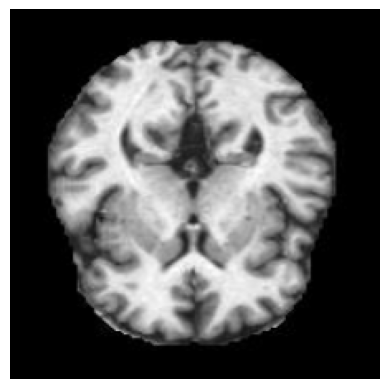

In [14]:
plt.imshow(images[500], cmap='gray')
plt.axis('off')

## Normalise Pixels

The image data range from 0-255 so pixel normalisation changes the range to 0-1.

In [15]:
images=images/255

In [16]:
np.max(images[600]) 

np.float64(1.0)

In [17]:
np.mean(images[600]) 

np.float64(0.30430453431372545)

## Image Augumentation 

In [18]:
! pip install pillow
from PIL import Image

In [130]:
def augment_image(img):

    # Basic PIL augmentations 
    img_aug = img.rotate(np.random.randint(-30, 31))  # random rotation

    if np.random.rand() > 0.5:
        img_aug = img_aug.transpose(Image.FLIP_LEFT_RIGHT)
    if np.random.rand() > 0.8:
        img_aug = img_aug.transpose(Image.FLIP_TOP_BOTTOM)

    # Brightness and contrast using Pillow
    img_aug = ImageEnhance.Brightness(img_aug).enhance(np.random.uniform(0.8, 1.2))
    img_aug = ImageEnhance.Contrast(img_aug).enhance(np.random.uniform(0.8, 1.2))

    # Optional Gaussian blur
    if np.random.rand() > 0.7:
        blur_radius = np.random.uniform(0.5, 2.0)
        img_aug = img_aug.filter(ImageFilter.GaussianBlur(radius=blur_radius))

   
    
    # Convert to NumPy array for OpenCV operations 
    img_cv = np.array(img_aug) 

    # CLAHE (Contrast Limited Adaptive Histogram Equalisation)
    if np.random.rand() > 0.5:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_cv = clahe.apply(img_cv)

    # Binary threshold (optional)
    if np.random.rand() > 0.7:
        _, img_cv = cv2.threshold(img_cv, np.random.randint(100,150), 255, cv2.THRESH_BINARY)

    # Otsu's thresholding (optional)
    if np.random.rand() > 0.7:
        _, img_cv = cv2.threshold(img_cv, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Canny edge detection (optional)
    if np.random.rand() > 0.9:
        low = np.random.randint(50, 100)
        high = np.random.randint(150, 200)
        img_cv = cv2.Canny(img_cv, threshold1=low, threshold2=high)

    # Convert back to PIL
    img_aug = Image.fromarray(img_cv)

    return img_aug



In [131]:
from PIL import Image, ImageEnhance, ImageFilter

#LOOP THROUGH CLASSES & AUGMENT
classes = ["NoImpairment", "MildImpairment", "ModerateImpairment"]

for cls in classes:
    input_folder = os.path.join(path, cls)
    output_folder = os.path.join(augmented_folder, cls)
    os.makedirs(output_folder, exist_ok=True)

    images = [f for f in os.listdir(input_folder) if f.lower().endswith(valid_ext)]

    for image_name in images:
        img_path = os.path.join(input_folder, image_name)
        img = Image.open(img_path)

        # Save original image
        img.save(os.path.join(output_folder, image_name))

        # Create augmented images
        for i in range(num_augmented_per_image):
            img_aug = augment_image(img)
            base_name, ext = os.path.splitext(image_name)
            new_name = f"{base_name}_aug{i}{ext}"
            img_aug.save(os.path.join(output_folder, new_name))

print("✅ Dataset augmentation complete with CLAHE, Canny, thresholding, blur, and contrast!")

✅ Dataset augmentation complete with CLAHE, Canny, thresholding, blur, and contrast!


Looking at original images for each impairment level

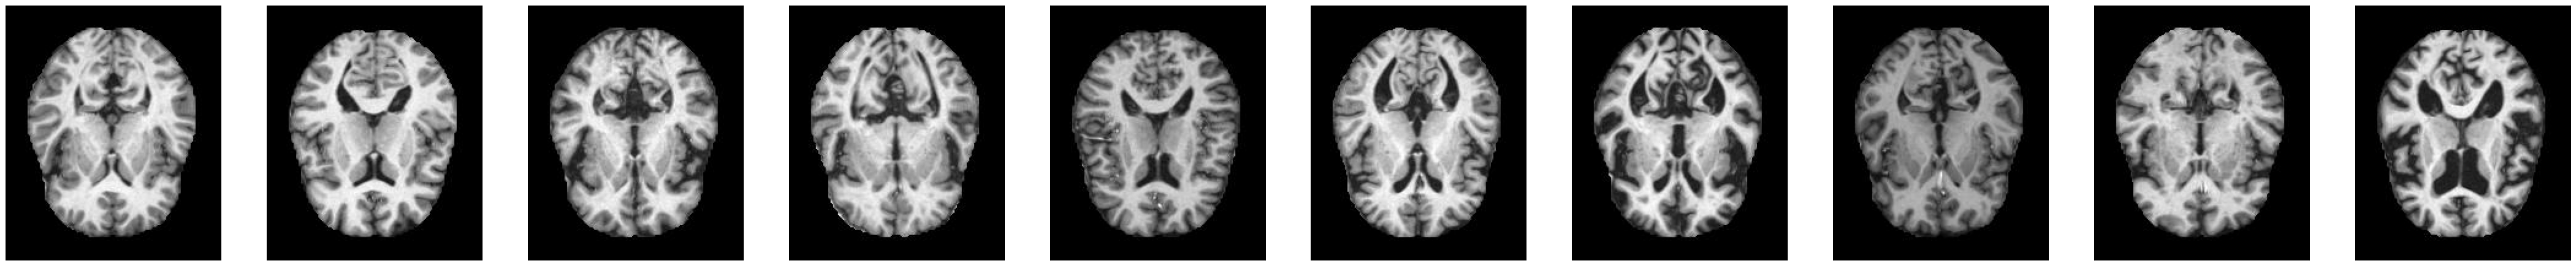

In [61]:
num_images=10

valid_ext = ('.png', '.jpg', '.jpeg') #prevents IsNotADirectory errors and UnidentifiedImage errors

images_no = [
    f for f in os.listdir(NoImpairment)
    if f.lower().endswith(valid_ext)  #prevents IsNotADirectory errors and UnidentifiedImage errors
]

plt.figure(figsize=(60, 6))
for i, name in enumerate(images_no[:num_images]):
    img_path = os.path.join(NoImpairment, name)
    img = Image.open(img_path)
    plt.subplot(1, num_images, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')


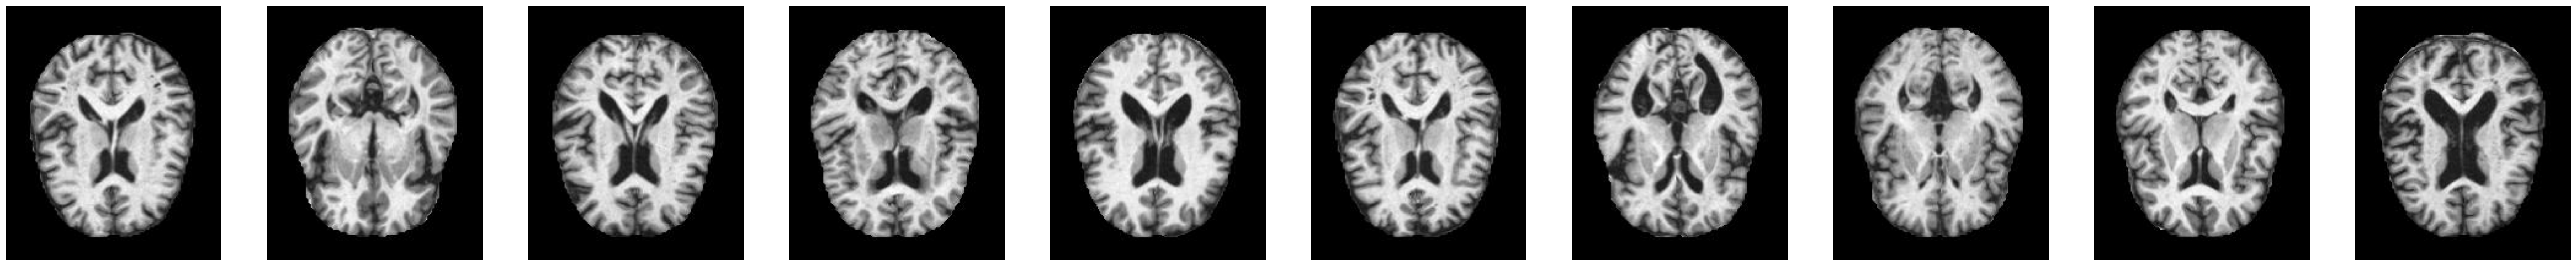

In [62]:
valid_ext = ('.png', '.jpg', '.jpeg')

images_no = [
    f for f in os.listdir(MildImpairment)
    if f.lower().endswith(valid_ext)
]

images_mild = os.listdir(MildImpairment)

plt.figure(figsize=(60, 6))
for i, name in enumerate(images_mild[:num_images]):
    img_path = os.path.join(MildImpairment, name)
    img = Image.open(img_path)
    plt.subplot(1, num_images, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')


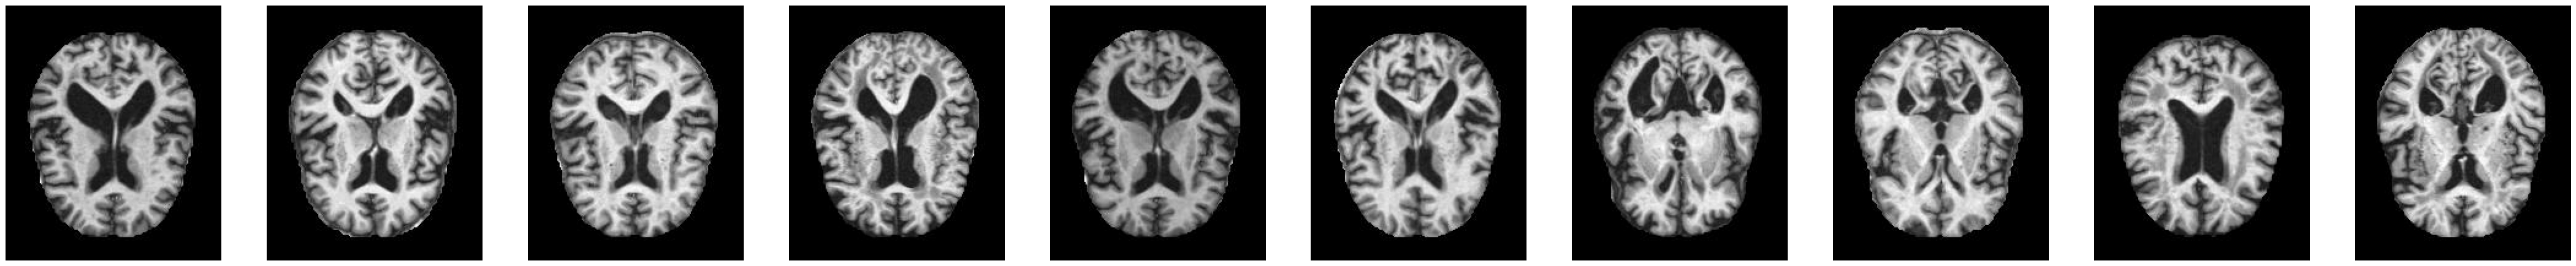

In [63]:
valid_ext = ('.png', '.jpg', '.jpeg')

images_no = [
    f for f in os.listdir(ModerateImpairment)
    if f.lower().endswith(valid_ext)
]
images_mod = os.listdir(ModerateImpairment)

plt.figure(figsize=(60, 6))
for i, name in enumerate(images_mod[:num_images]):
    img_path = os.path.join(ModerateImpairment, name)
    img = Image.open(img_path)
    plt.subplot(1, num_images, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')




In [33]:
# Here we are choosing a random image  
import numpy as np

# Pick a random image 
rand_image = np.random.randint(len(images_no))
print(f' We are using image {rand_image} from the scans with no impairment')
image_name=images_no[rand_image]
img_path = os.path.join(NoImpairment, image_name)
img = Image.open(img_path)

 We are using image 1 from the scans with no impairment


(np.float64(-0.5), np.float64(175.5), np.float64(207.5), np.float64(-0.5))

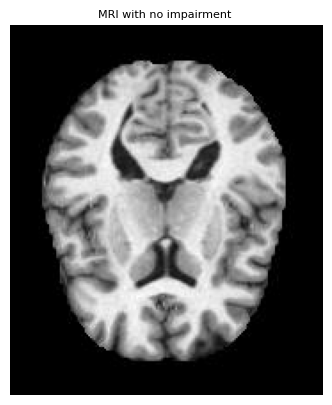

In [34]:
plt.imshow(img, cmap='gray')
plt.title(f"MRI with no impairment ",fontsize=8)
plt.axis('off')

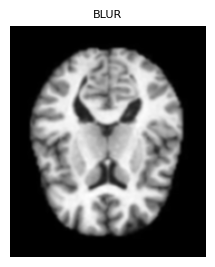

In [37]:
# blur with a 5x5 kernel
plt.figure(figsize=(3,3))
img_np = np.array(img)
blur_img = cv2.GaussianBlur(img_np, (5, 5), 0)
plt.imshow(blur_img, cmap='gray')
plt.title(f"BLUR",fontsize =8)
plt.axis('off')
plt.show()

In [38]:
# We can save the new image as a image file
cv2.imwrite("blurimage.png", blur_img) 

True

(np.float64(-0.5), np.float64(175.5), np.float64(207.5), np.float64(-0.5))

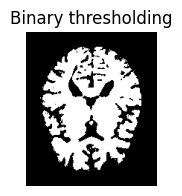

In [40]:
# Here we are using 128 as the threshold (half way)
_, thresh_img = cv2.threshold(img_np, 128, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(2,2))
plt.imshow(thresh_img, cmap='gray')
plt.title("Binary thresholding")
plt.axis('off')

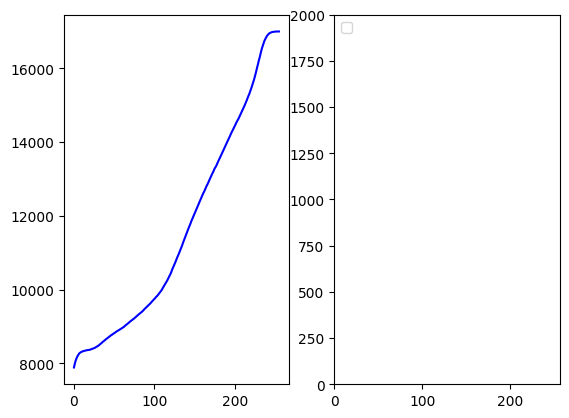

In [41]:
hist,bins = np.histogram(img_np.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
fig,ax=plt.subplots(1,2) 
ax[0].plot(cdf_normalized, color = 'b')
plt.legend(('cdf'), loc = 'upper left')
ax[1].hist(img_np.flatten(), bins=256, range=(0,1), color = 'r')
plt.ylim([0,2000])
plt.xlim([0,256])
plt.show()

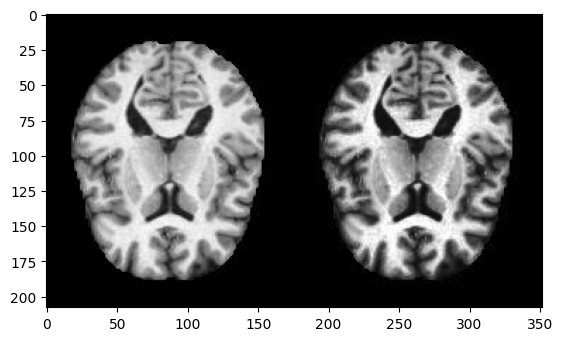

In [42]:
he_img = cv2.equalizeHist(img_np)
res = np.hstack((img_np,he_img)) #stacking images side-by-side
plt.imshow(res,cmap='gray')

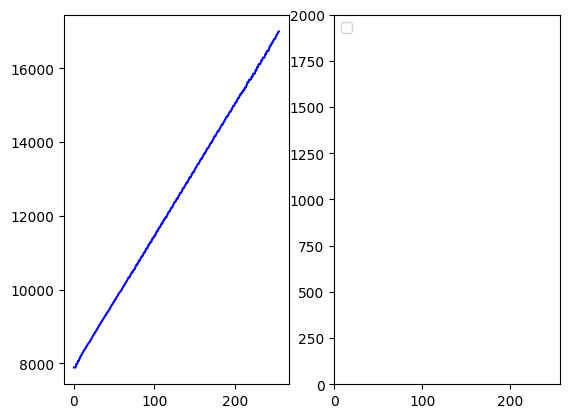

In [43]:
hist,bins = np.histogram(he_img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
fig,ax=plt.subplots(1,2) 
ax[0].plot(cdf_normalized, color = 'b')
plt.legend(('cdf'), loc = 'upper left')
ax[1].hist(he_img.flatten(),bins=256, range=(0,1), color = 'r')
plt.ylim([0,2000])
plt.xlim([0,256])
plt.show()

(np.float64(-0.5), np.float64(175.5), np.float64(207.5), np.float64(-0.5))

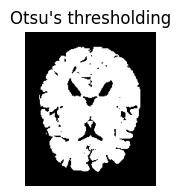

In [44]:
## Image segmentation using Otsu's Thresholding using OpenCV                                                      
_, segmented_img = cv2.threshold(img_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(2,2))
plt.imshow(segmented_img, cmap='gray')
plt.title("Otsu's thresholding")
plt.axis('off')


(np.float64(-0.5), np.float64(175.5), np.float64(207.5), np.float64(-0.5))

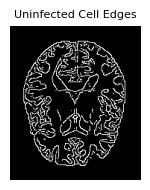

In [45]:
# Apply edge detection (Canny)
edges = cv2.Canny(img_np, 180, 200)
plt.figure(figsize=(2,2))
plt.imshow(edges, cmap='gray')
plt.title(f"Uninfected Cell Edges",fontsize =8)
plt.axis('off')

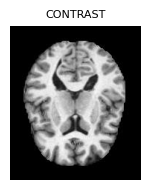

In [46]:
# Pillow library 
from PIL import ImageEnhance
# Adjust contrast using PIL ImageEnhance
enhancer = ImageEnhance.Contrast(img)
contrast_img = enhancer.enhance(1.0)      
contrast_img_np = np.array(contrast_img)
plt.figure(figsize=(2,2))
plt.imshow(contrast_img, cmap='gray')
plt.title(f"CONTRAST",fontsize =8)
plt.axis('off')
plt.show()

In [65]:
# We can save the image using PIL save function
contrast_img.save("newcontrast.png")

### Contrast Limited Adaptive HE (CLAHE)

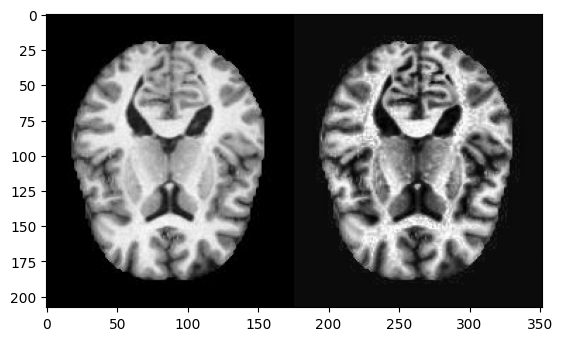

In [70]:
# create a CLAHE object (Arguments are optional).
limit=10
clahe = cv2.createCLAHE(clipLimit=limit, tileGridSize=(8,8))
clahe_img = clahe.apply(img_np)
res = np.hstack((img_np,clahe_img)) #stacking images side-by-side
plt.imshow(res,cmap='gray')

/var/folders/k2/4rg347055jj2_b20pxbz89100000gn/T/ipykernel_4155/3031419774.py:7: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  ax[1].hist(clahe_img.flatten(),256,[0,256], color = 'r')


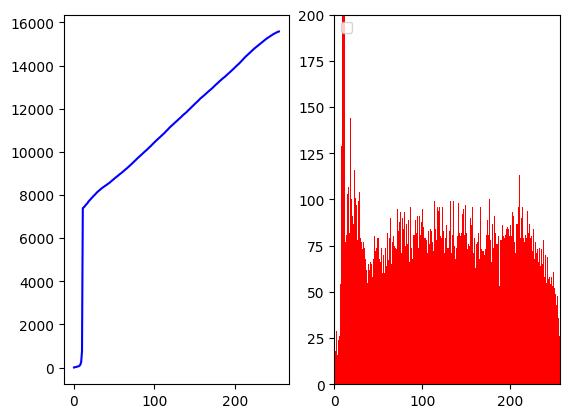

In [71]:
hist,bins = np.histogram(clahe_img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
fig,ax=plt.subplots(1,2) 
ax[0].plot(cdf_normalized, color = 'b')
plt.legend(('cdf'), loc = 'upper left')
ax[1].hist(clahe_img.flatten(),256,[0,256], color = 'r')
plt.ylim([0,200])
plt.xlim([0,256])
plt.show()

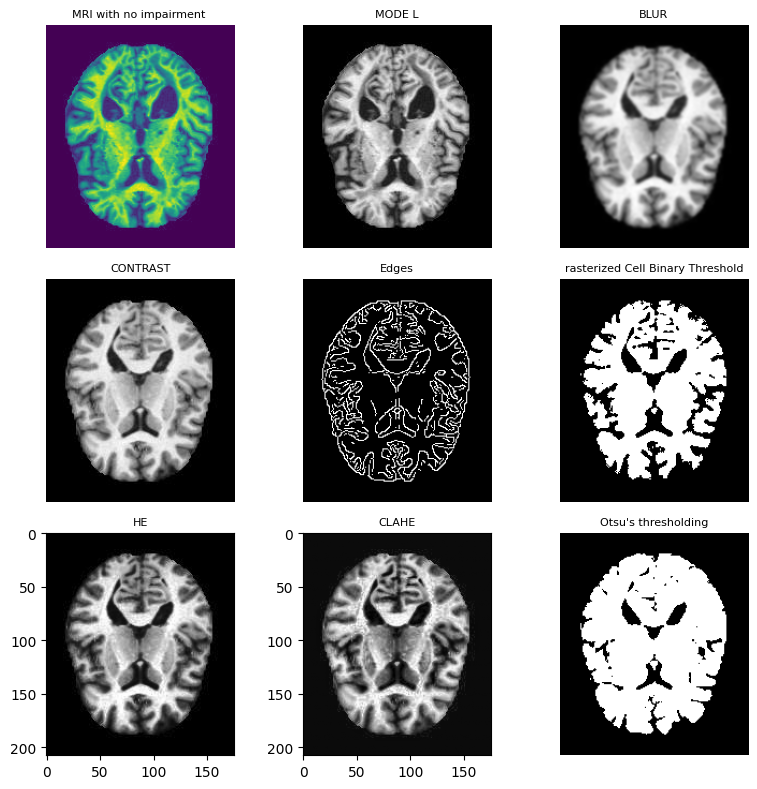

In [81]:
##### plot them in two rows
plt.figure(figsize=(8, 8))

plt.subplot(3, 3, 1)
plt.imshow(img)
plt.title(f"MRI with no impairment ",fontsize =8)
plt.axis('off')

plt.subplot(3,3, 2)
plt.imshow(img, cmap='gray')
plt.title(f"MODE L",fontsize =8)
plt.axis('off')

plt.subplot(3, 3, 3)
plt.imshow(blur_img, cmap='gray')
plt.title(f"BLUR",fontsize =8)
plt.axis('off')

plt.subplot(3,3, 4)
plt.imshow(contrast_img, cmap='gray')
plt.title(f"CONTRAST",fontsize =8)
plt.axis('off')

plt.subplot(3, 3, 5)
plt.imshow(edges, cmap='gray')
plt.title(f"Edges",fontsize =8)
plt.axis('off')

plt.subplot(3, 3, 6)
plt.imshow(thresh_img, cmap='gray')
plt.title(f"rasterized Cell Binary Threshold",fontsize =8)
plt.axis('off')

plt.subplot(3, 3, 7)
plt.title(f"HE",fontsize =8)
plt.imshow(he_img,cmap='gray')

plt.subplot(3,3, 8)
plt.title(f"CLAHE",fontsize =8)
plt.imshow(clahe_img,cmap='gray')

plt.subplot(3, 3, 9)
plt.imshow(segmented_img, cmap='gray')
plt.title(f"Otsu's thresholding",fontsize =8)
plt.axis('off')

plt.tight_layout()
plt.show()

In [110]:
# Repeat for the mild impairment  images

rand_image = np.random.randint(len(images_no))


print(f' We are using image {rand_image} from the scans with mild impairment')
image_name=images_no[rand_image]
img_path = os.path.join(MildImpairment, image_name)
img = Image.open(img_path)



 We are using image 75 from the scans with mild impairment


## Train the Model

Split the data into a training set and a test set to train the model on the different classes and test the model's prediction accuracy. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=142)

In [ ]:
y_train[190:250]

In [ ]:
print('Dataset splits %s' % Counter(y_train))

In [ ]:
print('Dataset splits %s' % Counter(y_test))

Turn the categorical classes into numerical binary 

In [ ]:
#one-hot-encoding for training set
y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes=3)
#for test set
y_test_ohe= tf.keras.utils.to_categorical(y_test, num_classes=3)

In [ ]:
y_test_ohe[195:200]

## Define the Convolutional Neural Network Model

Define the shape of the image and labels, as well as input shape (colour).

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import Flatten, Dense, Rescaling

# Define the CNN model
# Here we are using colour images so the dimensions are 150,150,3 rather than 150,150,1
# We define a series of sequential layers consisting of convolution layers(2d) and pooling layers
# Notice how the number of nodes within a layer are multiples of 2 - this more efficient for the optimiser
# Finally we flatten the data and pass into a fully-connected(dense) layer and then into the output layer
# The final activation function is a sigmoid function. We could have used a softmax function(with dense(2) outputs) - either would work.
model = Sequential( [
 Input(shape=(224,224,1)),
 #Rescaling(1./255),   # Rescale the colour to be between 0 and 1  - we have already done this in load_images function
 Conv2D(32, (3, 3), activation='relu'), # Use 30 filters with a 3x3 kernel
 MaxPooling2D(pool_size=(2, 2)),
 Conv2D(64, (3, 3), activation='relu'), # Increase number of filters
 MaxPooling2D(pool_size=(2, 2)),
 Conv2D(128, (3, 3), activation='relu'), # Increase number of filters
 MaxPooling2D(pool_size=(2, 2)),
 Flatten(),
 Dense(512, activation='relu'),  # Put into a dense layer size
 Dense(1, activation='sigmoid')  # Gives probability between 0 and 1
] )

## Define the Running of the Model

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Print the model summary
model.summary()

## Fit and Train the Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

#early stopping 
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(x=X_train, y=y_train, batch_size=100,
                      epochs=30, shuffle=True,
                      validation_split=0.2, callbacks=[early_stop])


In [ ]:
epochs = history.epoch

In [ ]:
accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']

# If the validation accuracy or loss differ significantly from the training, this is evidence of overfitting
plt.figure(figsize=(8, 4))
plt.plot(epochs, accuracy_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
